#### Imports and paths

In [2]:
import os
import math
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch_geometric.nn import GCNConv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


#### Hyperparameters & Paths

In [4]:
# Data / model paths
data_path = "../data/processed/model_ready.pt"
graph_path = "../data/processed/graph_structure.pt"
model_save_path = "models/best_gcn_gru.pt"

os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Model hyperparameters
gcn_hidden_dim = 16   # smaller to reduce overfitting
gru_hidden_dim = 32   # smaller GRU
dropout_prob = 0.10

# Training hyperparameters
batch_size = 32
max_epochs = 100
patience = 10    # early stopping patience
learning_rate = 1e-3
weight_decay = 1e-5    # L2 regularization

#### Data Loading

In [5]:
bundle = torch.load(data_path, map_location="cpu", weights_only=False)
graph_data = torch.load(graph_path, map_location="cpu", weights_only=True)

X_train = bundle["X_train"].float()
Y_train = bundle["Y_train"].float()
X_val   = bundle["X_val"].float()
Y_val   = bundle["Y_val"].float()
X_test  = bundle["X_test"].float()
Y_test  = bundle["Y_test"].float()
scaler  = bundle["scaler"]   # for inverse-transform later if needed

edge_index = graph_data["edge_index"]

print("Data shapes:")
print(f" X_train: {X_train.shape}")
print(f" Y_train: {Y_train.shape}")
print(f" X_val: {X_val.shape}")
print(f" Y_val: {Y_val.shape}")
print(f" X_test: {X_test.shape}")
print(f" Y_test: {Y_test.shape}")
print(f" edge_index: {edge_index.shape}")

Data shapes:
 X_train: torch.Size([11001, 12, 12, 9])
 Y_train: torch.Size([11001, 3, 12])
 X_val: torch.Size([2145, 12, 12, 9])
 Y_val: torch.Size([2145, 3, 12])
 X_test: torch.Size([2215, 12, 12, 9])
 Y_test: torch.Size([2215, 3, 12])
 edge_index: torch.Size([2, 24])


#### DataLoaders

In [6]:
train_loader = DataLoader(
    TensorDataset(X_train, Y_train),
    batch_size=batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    TensorDataset(X_val, Y_val),
    batch_size=batch_size,
    shuffle=False,
)

test_loader = DataLoader(
    TensorDataset(X_test, Y_test),
    batch_size=batch_size,
    shuffle=False,
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches:   {len(val_loader)}")
print(f"Test batches:  {len(test_loader)}")

Train batches: 344
Val batches:   68
Test batches:  70


#### Model Definition (GCN + GRU with dropout & smaller dims)

In [7]:
class GCNGRUForecaster(nn.Module):
    def __init__(
        self,
        in_channels: int,
        gcn_hidden_dim: int,
        gru_hidden_dim: int,
        pred_len: int,
        num_nodes: int,
        edge_index: torch.Tensor,
        dropout: float = 0.3,
    ):
        super().__init__()
        self.num_nodes = num_nodes
        self.pred_len = pred_len

        self.gcn = GCNConv(in_channels, gcn_hidden_dim)

        # Use 2 layers so GRU's builtin dropout is actually applied
        self.gru = nn.GRU(
            input_size=gcn_hidden_dim,
            hidden_size=gru_hidden_dim,
            num_layers=2, 
            batch_first=True,
            dropout=dropout,
        )


        self.fc = nn.Linear(gru_hidden_dim, pred_len)
        self.dropout = nn.Dropout(dropout)

        # store graph as buffer
        self.register_buffer("edge_index", edge_index)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        X: [B, T, N, F]
        Returns: [B, T_out, N]
        """
        B, T, N, F = X.shape

        # Spatial GCN per timestep
        gcn_outputs = []
        for t in range(T):
            Xt = X[:, t, :, :]          # [B, N, F]
            Xt_flat = Xt.reshape(-1, F) # [B*N, F]

            # Expand edge_index for all batches
            edge_list = []
            for b in range(B):
                offset = b * N
                edges = self.edge_index + offset
                edge_list.append(edges)

            batch_edge_index = torch.cat(edge_list, dim=1)

            gcn_out = self.gcn(Xt_flat, batch_edge_index)   # [B*N, gcn_hidden_dim]
            gcn_out = self.dropout(gcn_out)
            gcn_out = gcn_out.reshape(B, N, -1)              # [B, N, gcn_hidden_dim]

            gcn_outputs.append(gcn_out.unsqueeze(1))         # [B, 1, N, gcn_hidden_dim]

        # [B, T, N, gcn_hidden_dim]
        gcn_hidden = torch.cat(gcn_outputs, dim=1)

        # GRU over time, per node: reshape to [B*N, T, gcn_hidden_dim]
        gru_in = gcn_hidden.permute(0, 2, 1, 3).reshape(B * N, T, -1)
        gru_out, _ = self.gru(gru_in)

        # Take last hidden state over time
        last_hidden = gru_out[:, -1, :]          # [B*N, gru_hidden_dim]
        out = self.fc(last_hidden)               # [B*N, pred_len]

        # Reshape back to [B, pred_len, N]
        out = out.view(B, N, self.pred_len).permute(0, 2, 1)
        return out

#### Instantiate Model, Loss, Optimizer

In [8]:
_, T_in, N, F_in = X_train.shape
_, T_out, _      = Y_train.shape

model = GCNGRUForecaster(
    in_channels=F_in,
    gcn_hidden_dim=gcn_hidden_dim,
    gru_hidden_dim=gru_hidden_dim,
    pred_len=T_out,
    num_nodes=N,
    edge_index=edge_index,
    dropout=dropout_prob,
).to(device)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
)

total_params = sum(p.numel() for p in model.parameters())
print(model)
print(f"Total parameters: {total_params}")

GCNGRUForecaster(
  (gcn): GCNConv(9, 16)
  (gru): GRU(16, 32, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=32, out_features=3, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Total parameters: 11395


#### Training / Evaluation Helpers (with no_grad + logging)

In [9]:
def run_epoch(loader, model, criterion, device, optimizer=None):
    if optimizer is None:
        model.eval()
        mode = "EVAL"
    else:
        model.train()
        mode = "TRAIN"

    total_loss = 0.0
    total_count = 0

    for batch_idx, (X_batch, Y_batch) in enumerate(loader):
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        if optimizer is not None:
            optimizer.zero_grad()
            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                Y_pred = model(X_batch)
                loss = criterion(Y_pred, Y_batch)

        total_loss += loss.item() * X_batch.size(0)
        total_count += X_batch.size(0)

    return total_loss / total_count


#### Training Loop with Early Stopping

In [28]:
best_val = float("inf")
best_epoch = -1
wait = 0

train_losses = []
val_losses = []

print("Starting training...")

for epoch in range(1, max_epochs + 1):
    train_loss = run_epoch(train_loader, model, criterion, device, optimizer)
    val_loss = run_epoch(val_loader, model, criterion, device, optimizer=None)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    improved = val_loss < best_val - 1e-5  # tiny margin
    if improved:
        best_val = val_loss
        best_epoch = epoch
        wait = 0
        torch.save(model.state_dict(), model_save_path)
        status = " (saved best)"
    else:
        wait += 1
        status = ""

    print(
        f"Epoch {epoch:03d} | "
        f"Train: {train_loss:.4f} | Val: {val_loss:.4f} | "
        f"Patience: {wait}/{patience}{status}"
    )

    if wait >= patience:
        print(f"Early stopping at epoch {epoch}. Best epoch: {best_epoch}, Val: {best_val:.4f}")
        break
    
torch.save(model, model_save_path)
print(f"Training finished. Best validation loss: {best_val:.4f} at epoch {best_epoch}")


Starting training...
Epoch 001 | Train: 0.4553 | Val: 0.4010 | Patience: 0/10 (saved best)
Epoch 002 | Train: 0.4152 | Val: 0.3812 | Patience: 0/10 (saved best)
Epoch 003 | Train: 0.4026 | Val: 0.3800 | Patience: 0/10 (saved best)
Epoch 004 | Train: 0.3924 | Val: 0.3656 | Patience: 0/10 (saved best)
Epoch 005 | Train: 0.3861 | Val: 0.3722 | Patience: 1/10
Epoch 006 | Train: 0.3811 | Val: 0.3613 | Patience: 0/10 (saved best)
Epoch 007 | Train: 0.3774 | Val: 0.3590 | Patience: 0/10 (saved best)
Epoch 008 | Train: 0.3735 | Val: 0.3592 | Patience: 1/10
Epoch 009 | Train: 0.3698 | Val: 0.3585 | Patience: 0/10 (saved best)
Epoch 010 | Train: 0.3670 | Val: 0.3577 | Patience: 0/10 (saved best)
Epoch 011 | Train: 0.3643 | Val: 0.3496 | Patience: 0/10 (saved best)
Epoch 012 | Train: 0.3617 | Val: 0.3518 | Patience: 1/10
Epoch 013 | Train: 0.3591 | Val: 0.3528 | Patience: 2/10
Epoch 014 | Train: 0.3570 | Val: 0.3485 | Patience: 0/10 (saved best)
Epoch 015 | Train: 0.3547 | Val: 0.3559 | Patience:

#### Load Best Model & Evaluate on Test Set

In [10]:
#Recreate the model with the EXACT same architecture
model = GCNGRUForecaster(
    in_channels=F_in,
    gcn_hidden_dim=gcn_hidden_dim,  # 16
    gru_hidden_dim=gru_hidden_dim,  # 32
    pred_len=T_out,
    num_nodes=N,
    edge_index=edge_index,
    dropout=dropout_prob,
).to(device)

#Load the model
model = torch.load(model_save_path, map_location=device)
model.to(device)
model.eval()

test_loss = run_epoch(test_loader, model, criterion, device, optimizer=None)
print(f"Test MAE (normalized scale): {test_loss:.4f}")

/tmp/ipykernel_8835/1215355234.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_save_path, map_location=device)


Test MAE (normalized scale): 0.3588


#### Run model on test set and compute metrics (in scaled space)

In [11]:
# Fix the evaluate_scaled function first
def evaluate_scaled(loader, model, device):
    model.eval()
    all_preds = []
    all_targets = []
    
    for X_batch, Y_batch in loader:
        X_batch = X_batch.to(device)  # [B, T_in, N, F]
        Y_batch = Y_batch.to(device)  # [B, T_out, N]

        with torch.no_grad():
            Y_pred = model(X_batch)    # [B, T_out, N]

        all_preds.append(Y_pred.cpu())
        all_targets.append(Y_batch.cpu())

    preds = torch.cat(all_preds, dim=0)    # [S, T_out, N]
    targets = torch.cat(all_targets, dim=0)  # [S, T_out, N]

    mae = torch.mean(torch.abs(preds - targets)).item()
    rmse = torch.sqrt(torch.mean((preds - targets) ** 2)).item()
    eps = 1e-5
    mape = torch.mean(torch.abs((preds - targets) / (targets + eps))).item() * 100.0

    return preds.numpy(), targets.numpy(), mae, rmse, mape

# Then call the function and print results
preds_scaled, targets_scaled, test_mae_scaled, test_rmse_scaled, test_mape_scaled = evaluate_scaled(
    test_loader, model, device
)

# Fixed print statements - removed the syntax errors
print(f"Test MAE (scaled): {test_mae_scaled:.4f}")
print(f"Test RMSE (scaled): {test_rmse_scaled:.4f}")
print(f"Test MAPE (scaled): {test_mape_scaled:.2f}%")

Test MAE (scaled): 0.3588
Test RMSE (scaled): 0.4653
Test MAPE (scaled): 220.22%


#### Inverse-transform to real km/h and recompute metrics

In [12]:
import numpy as np

# Index of 'traffic_speed' in feature_cols used during scaling
speed_idx = 0   # change if traffic_speed was not the first feature

speed_mean = scaler.mean_[speed_idx]
speed_std  = scaler.scale_[speed_idx]

# Undo StandardScaler: x_real = x_scaled * std + mean
preds = preds_scaled * speed_std + speed_mean
targets = targets_scaled * speed_std + speed_mean

mae  = np.mean(np.abs(preds - targets))
rmse = np.sqrt(np.mean((preds - targets) ** 2))
mape = np.mean(np.abs((preds - targets) / (targets + 1e-5))) * 100.0

print("=== Test metrics in original units (km/h) ===")
print(f"MAE  : {mae:.3f} km/h")
print(f"RMSE : {rmse:.3f} km/h")
print(f"MAPE : {mape:.2f} %")

=== Test metrics in original units (km/h) ===
MAE  : 2.488 km/h
RMSE : 3.227 km/h
MAPE : 13.53 %


#### Quick visualization: predicted vs actual for one node

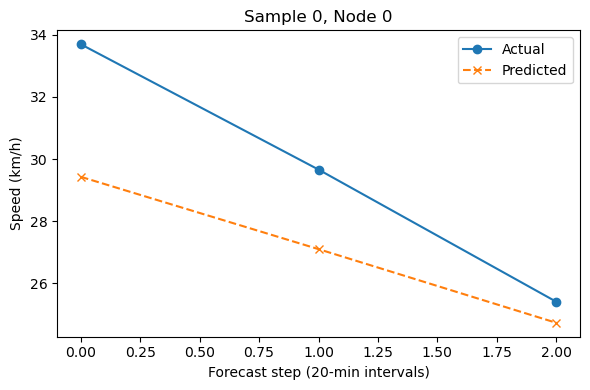

In [13]:
import matplotlib.pyplot as plt

# pick one sample and one road segment
sample_idx = 0     # which test sample
node_idx   = 0     # which segment (0..N-1)

pred_series = preds[sample_idx, :, node_idx]    # length = T_out
true_series = targets[sample_idx, :, node_idx]

plt.figure(figsize=(6,4))
plt.plot(true_series, label="Actual", marker="o")
plt.plot(pred_series, label="Predicted", marker="x", linestyle="--")
plt.xlabel("Forecast step (20-min intervals)")
plt.ylabel("Speed (km/h)")
plt.title(f"Sample {sample_idx}, Node {node_idx}")
plt.legend()
plt.tight_layout()
plt.savefig("../results/sample0_node0.png", dpi=300, bbox_inches="tight")

plt.show()

In [14]:
import torch, numpy as np

def last_value_baseline(loader, mean, std, T_out, device):
    preds, targets = [], []

    for X, Y in loader:
        X, Y = X.to(device), Y.to(device)
        last = X[:, -1, :, 0]                     # [B, N]
        preds.append(last.unsqueeze(1).repeat(1, T_out, 1).cpu())
        targets.append(Y.cpu())

    p = torch.cat(preds).numpy()   * std + mean
    t = torch.cat(targets).numpy() * std + mean

    mae  = np.mean(np.abs(p - t))
    rmse = np.sqrt(np.mean((p - t)**2))
    mape = np.mean(np.abs((p - t)/(t + 1e-6))) * 100
    return mae, rmse, mape


mae, rmse, mape = last_value_baseline(test_loader, speed_mean, speed_std, T_out, device)
print(f"Baseline MAE: {mae:.3f} km/h")
print(f"Baseline RMSE: {rmse:.3f} km/h")
print(f"Baseline MAPE: {mape:.2f}%")


Baseline MAE: 1.921 km/h
Baseline RMSE: 2.730 km/h
Baseline MAPE: 10.81%


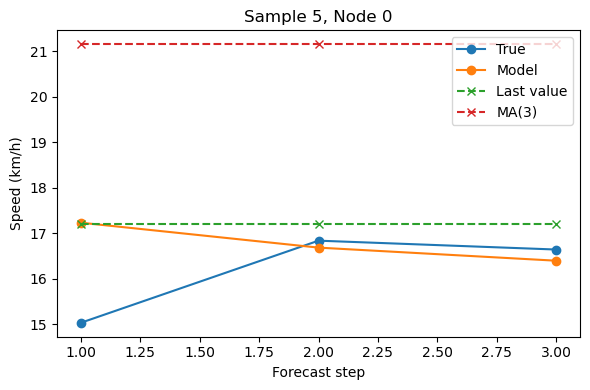

In [16]:
import torch, numpy as np, matplotlib.pyplot as plt


sample, node = 5, 0
Xb, Yb = next(iter(test_loader))
Xb, Yb = Xb.to(device), Yb.to(device)

# model + baselines
model.eval()
with torch.no_grad():
    pred_s = model(Xb)

last_s = Xb[:, -1, :, 0].unsqueeze(1).repeat(1, T_out, 1)
ma3_s  = Xb[:, -3:, :, 0].mean(1).unsqueeze(1).repeat(1, T_out, 1)

# pick sample/node
def pick(x): return x[sample, :, node].cpu().numpy()
true = pick(Yb)
pred = pick(pred_s)
last = pick(last_s)
ma3 = pick(ma3_s)

# inverse transform
def inv(x): return x * speed_std + speed_mean
true, pred, last, ma3 = map(inv, [true, pred, last, ma3])

# plot
steps = np.arange(1, T_out + 1)
plt.figure(figsize=(6,4))
plt.plot(steps, true, 'o-', label="True")
plt.plot(steps, pred, 'o-', label="Model")
plt.plot(steps, last, 'x--', label="Last value")
plt.plot(steps, ma3,  'x--', label="MA(3)")
plt.xlabel("Forecast step"); plt.ylabel("Speed (km/h)")
plt.title(f"Sample {sample}, Node {node}")
plt.legend(); plt.tight_layout()
plt.savefig("../results/sample_5_node0.png", dpi=300, bbox_inches="tight")

plt.show()




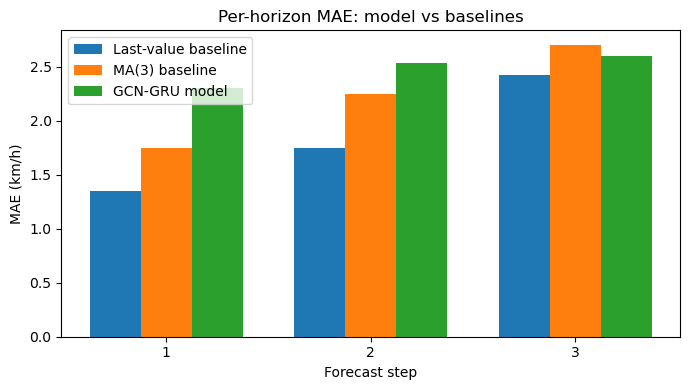

In [18]:
import matplotlib.pyplot as plt
import numpy as np

horizons = np.array([1, 2, 3])

last_val = np.array([1.35, 1.75, 2.42])
ma3 = np.array([1.75, 2.25, 2.70])
model = np.array([2.30, 2.53, 2.60])

width = 0.25

plt.figure(figsize=(7,4))

plt.bar(horizons - width, last_val, width, label="Last-value baseline")
plt.bar(horizons, ma3, width, label="MA(3) baseline")
plt.bar(horizons + width, model, width, label="GCN-GRU model")

plt.xlabel("Forecast step")
plt.ylabel("MAE (km/h)")
plt.title("Per-horizon MAE: model vs baselines")
plt.xticks(horizons)
plt.legend()
plt.tight_layout()
plt.savefig("../results/model_vs_baseline.png", dpi=300, bbox_inches="tight")

plt.show()
